# SVM Model

### Import libraries

In [25]:
import pandas as pd 
import numpy as np

from sklearn import svm

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

### Reading data file from "Featureengineering" output as .csv

In [26]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14579.56,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552


### Read "Feature importance list" from .csv

In [27]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


In [28]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [29]:
df_model = df[list_imp_feat].copy()

In [30]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

### Nan value treatment

In [31]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [32]:
df_model.dropna(inplace=True)

In [33]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180149 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180149 non-null  float64
 1   ME.FTS.act.dgC           180149 non-null  float64
 2   HFO.GME.act.nodim        180149 non-null  float64
 3   V.COG.act.deg            180149 non-null  float64
 4   V.SOG.act.kn             180149 non-null  float64
 5   V.RUA.act.deg            180149 non-null  float64
 6   V.GPSLAT.act.deg         180149 non-null  float64
 7   V.GPSLON.act.deg         180149 non-null  float64
 8   WEA.WDT.act.deg          180149 non-null  float64
 9   WEA.WST.act.mPs          180149 non-null  float64
 10  V.SLPOG.act.PRC          180149 non-null  float64
 11  ME.SFCI.act.gPkWh        180149 non-null  float64
 12  DDM.TRIM.act.m           180149 non-null  float64
 13  DDM.DRAFT.act.m          180149 non-null  float64
 14  pass

### Correlation Matrix

<AxesSubplot:>

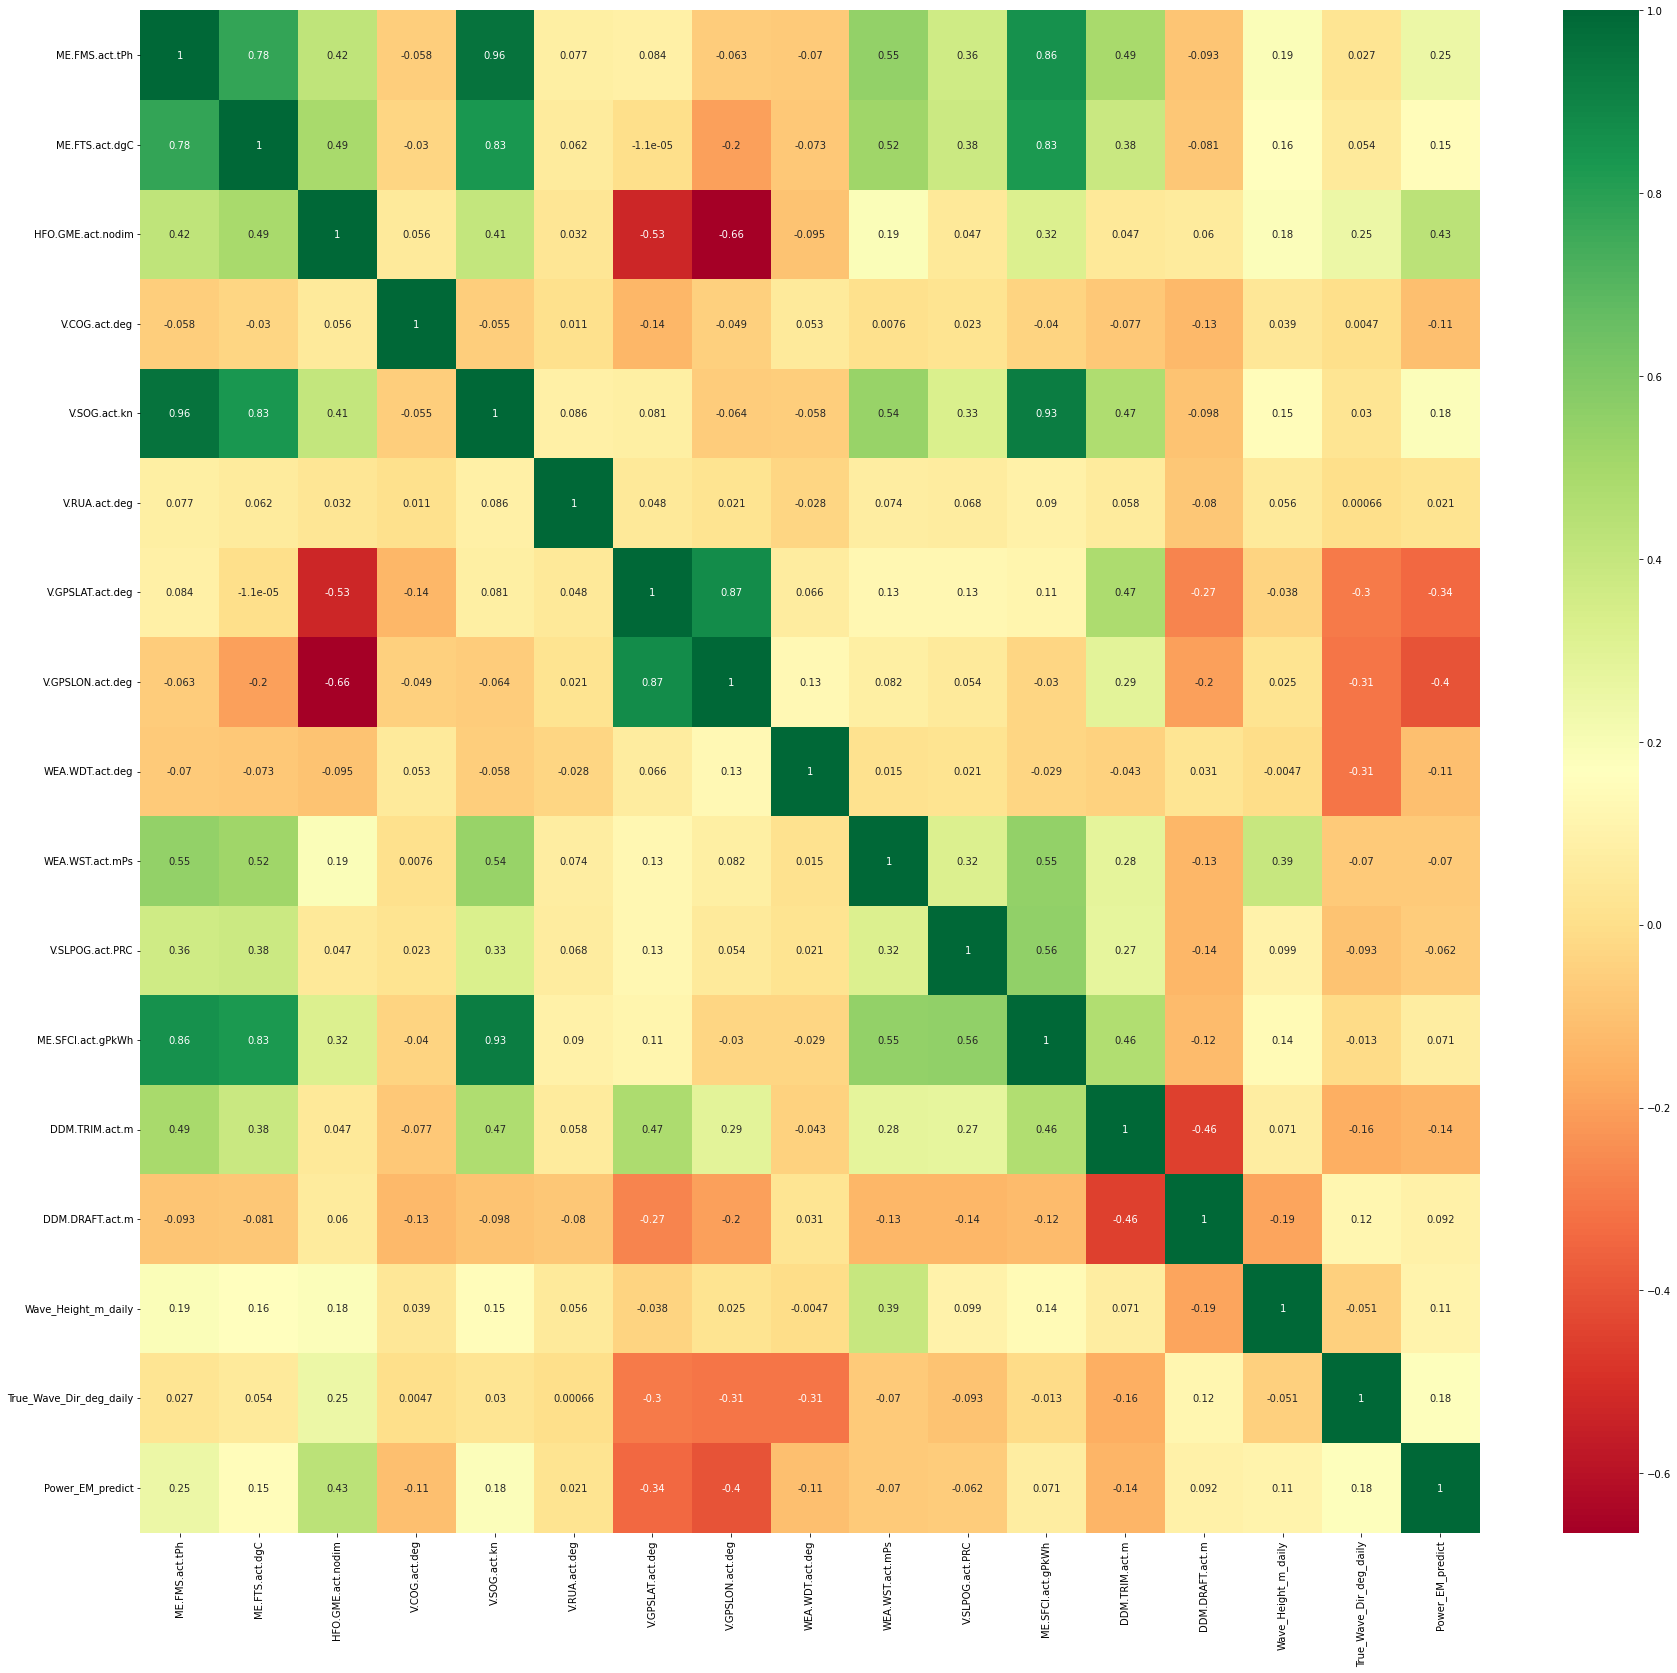

In [34]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Target and Feature definition

In [35]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

### Test train split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

### Dummy creation

In [37]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

### Open MLFlow and definition of run name

In [38]:
# setting the MLFlow connection and experiment
#mlflow.set_tracking_uri(TRACKING_URI)
#mlflow.set_experiment(EXPERIMENT_NAME)
#mlflow.start_run(run_name='SVM')
#run = mlflow.active_run()

### Pipline with SVM Regressor and parameter definition

In [39]:
clf = make_pipeline(MinMaxScaler(), svm.SVR(kernel='poly',
                                            gamma='scale',
                                            C=1.0,
                                            epsilon=0.1,
                                            ))

### Fit Model

In [40]:
clf.fit(X_train, y_train)

### Predict y

In [ ]:
y_pred = clf.predict(X_test)


### Predict y on train data

In [ ]:
y_pred_train = clf.predict(X_train)

In [ ]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

### Plot "Actuel" vs. "Predicted"

In [ ]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
#plt.xticks(np.arange(0,501,100));
#plt.yticks(np.arange(0,501,100));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");
#plt.xlim(0, 450);
#plt.ylim(0, 450);

### MLFlow paramaeters

In [ ]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)

params = {
       'csv used': 'Featureselection03.csv',
       'features drop' : 'Accroding to model importance list',
       'NaN handling': 'dropped',
       'Shape' : df.shape,
       'Scaler' : 'MinMaxScaler',
       'kernel' : 'linear',
       'gamma' : 'scale',
       'C' : 1.0,
       'epsilon' : 0.1
  }

### Writing to MLFlow

In [ ]:
#logging params to mlflow
#mlflow.log_params(params)

#setting tags
#mlflow.set_tag("running_from_jupyter", "True")

#logging metrics
#mlflow.log_metric("train-" + "RMSE", rmse_train)
#mlflow.log_metric("test-" + "RMSE", rmse_test)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
#mlflow.end_run()